In this notebook we try to set up data and models using the jraph library.

### imports and setup

In [465]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [489]:
from utils.jraph_data import lorenz_graph_tuple_list, print_graph_fts, get_data_windows, data_list_to_dict

from utils.jraph_vis import draw_jraph_graph_structure, plot_time_series_for_node, plot_rollout_for_node, plot_predictions

from utils.jraph_models import MLPBlock_fn, MLPGraphNetwork_fn, naive_const_fn, naive_zero_fn
from utils.jraph_training import train, evaluate

#### generic imports

In [467]:
import numpy as np

import matplotlib.pyplot as plt
from utils.plotters import plot_data

In [468]:
import jraph
import jax
import jax.numpy as jnp
import networkx as nx
import haiku as hk


In [469]:
# for training sequence
import functools
import optax
from typing import Any, Callable, Dict, List, Optional, Tuple, Iterable

In [470]:
# # Imports
# %matplotlib inline
# import jax.tree_util as tree
# import flax
# import pickle

### graph data structures

In [582]:
graph_tuple_lists = lorenz_graph_tuple_list(n_samples=200)
# 200 time steps -> 2 days
# 6 hrs -> 1/4 day = 25 time steps
# TODO: 6 means 6/100 of a day, convert this to hours later


done computing adj


In [583]:
print_graph_fts(graph_tuple_lists['train'][0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


#### visualization

visualize graph

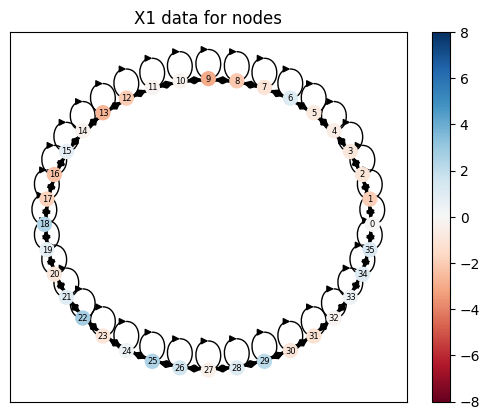

In [589]:
draw_jraph_graph_structure(graph_tuple_lists['train'][0])

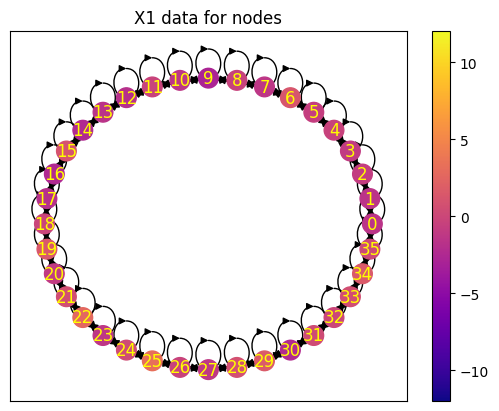

In [474]:
draw_jraph_graph_structure(graph_tuple_lists['train'][10])

visualize time series data

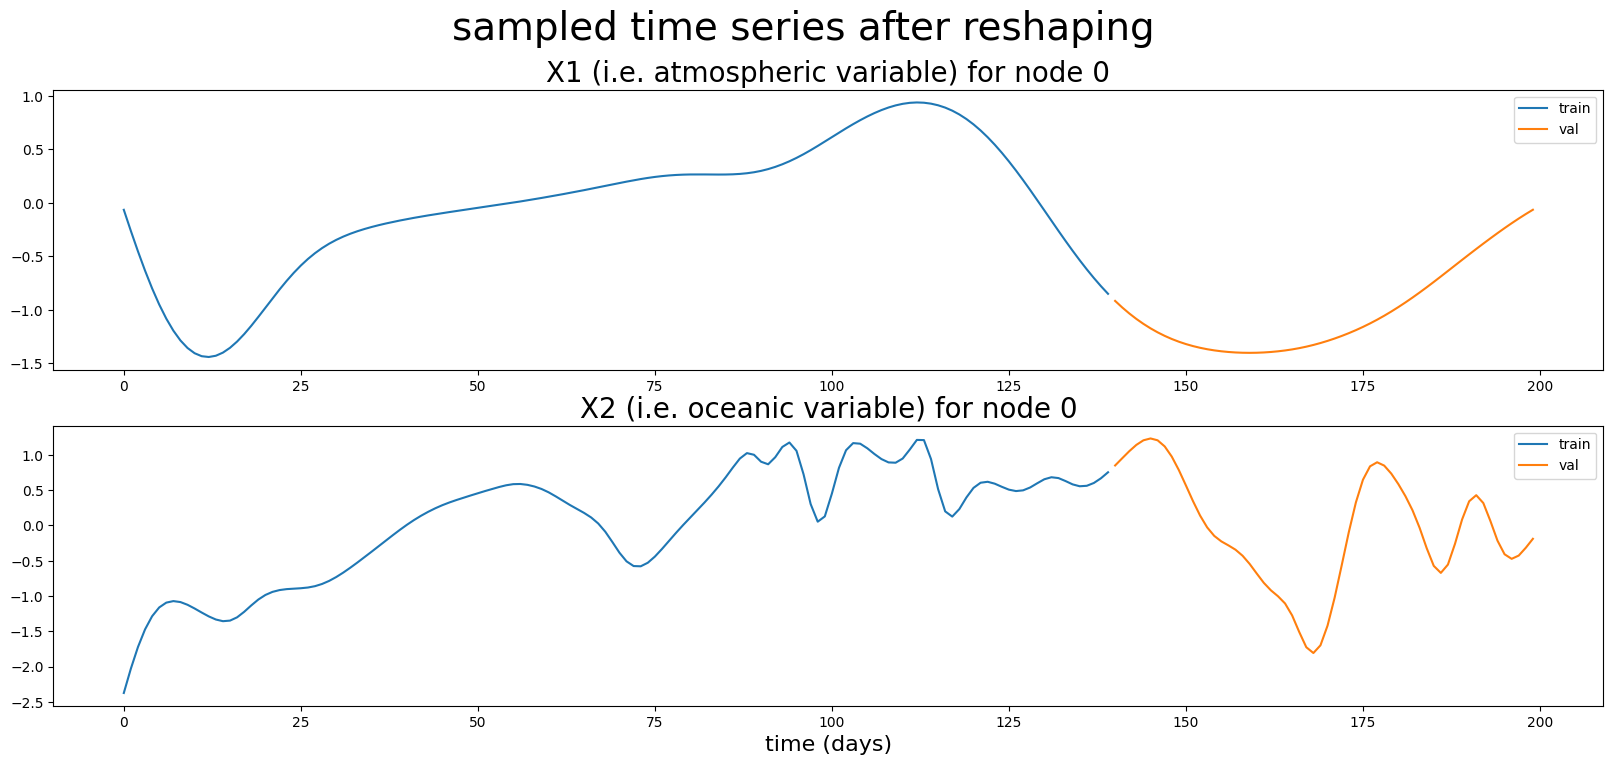

In [510]:
plot_time_series_for_node(graph_tuple_lists, node=0)

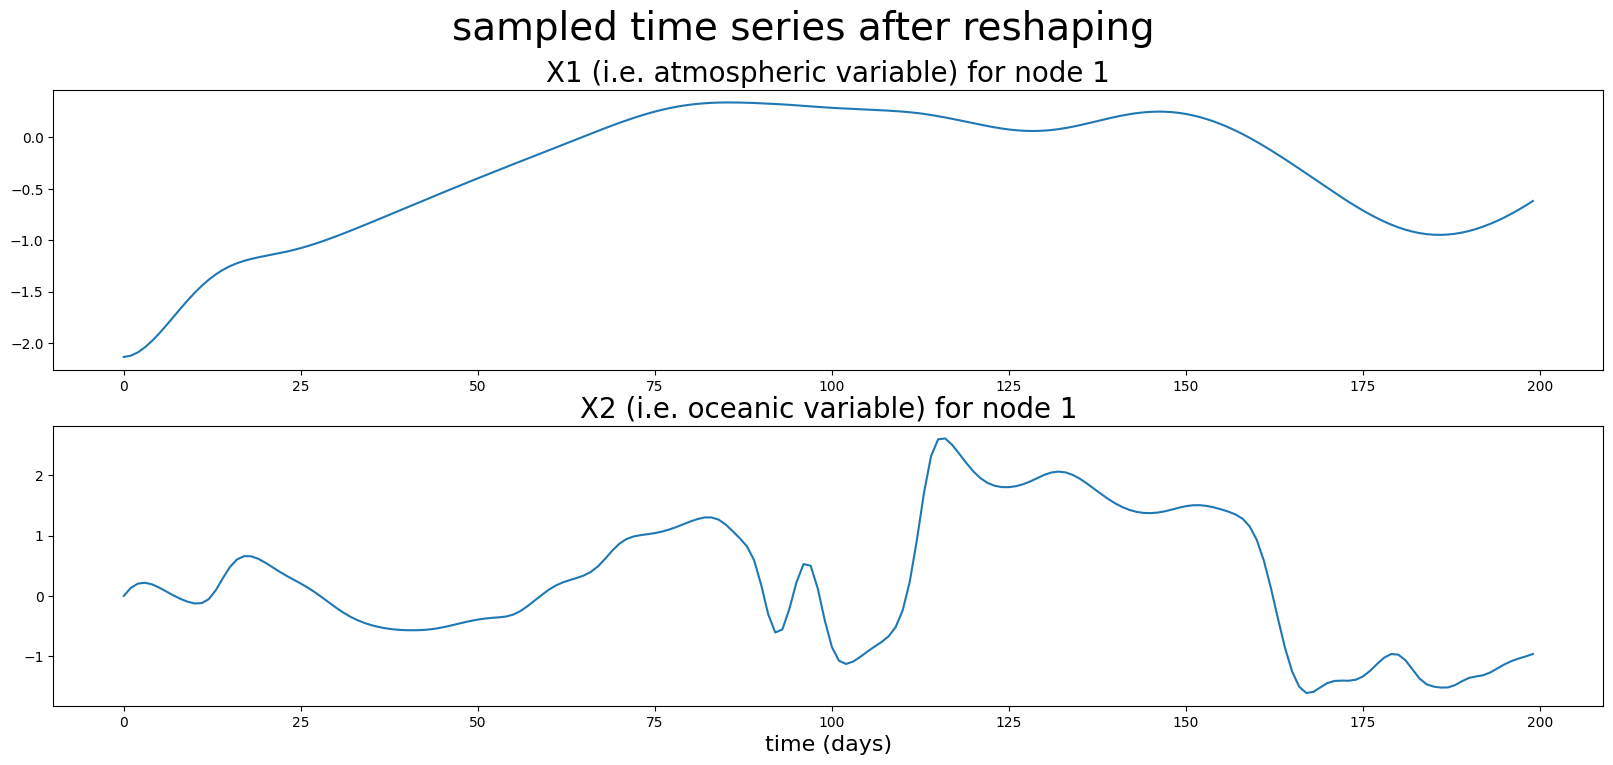

In [476]:
plot_time_series_for_node(graph_tuple_lists, node=1)

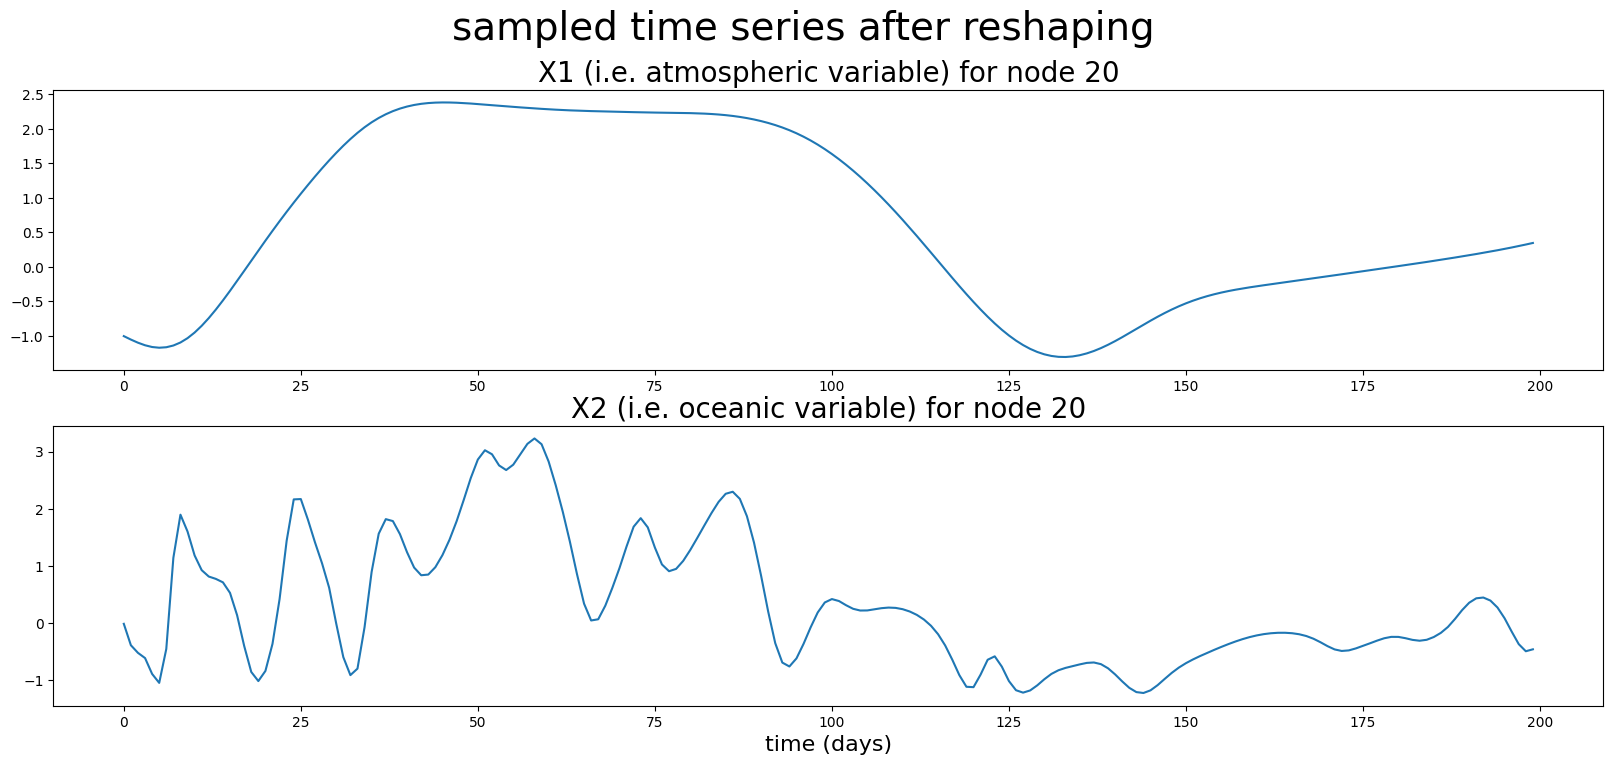

In [477]:
plot_time_series_for_node(graph_tuple_lists, node=20)

visualize input and target rollout data

140 90
60 10


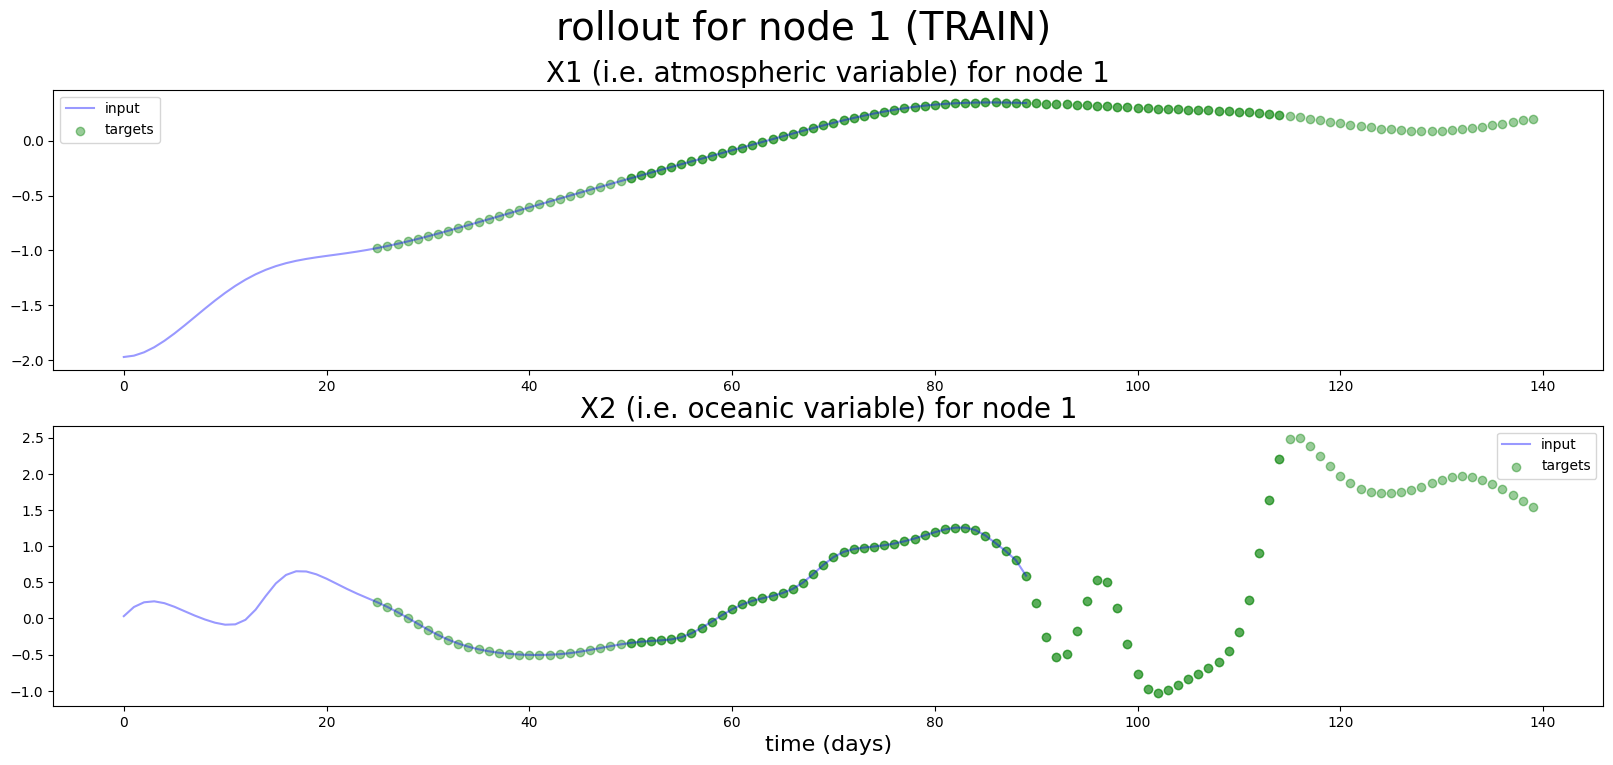

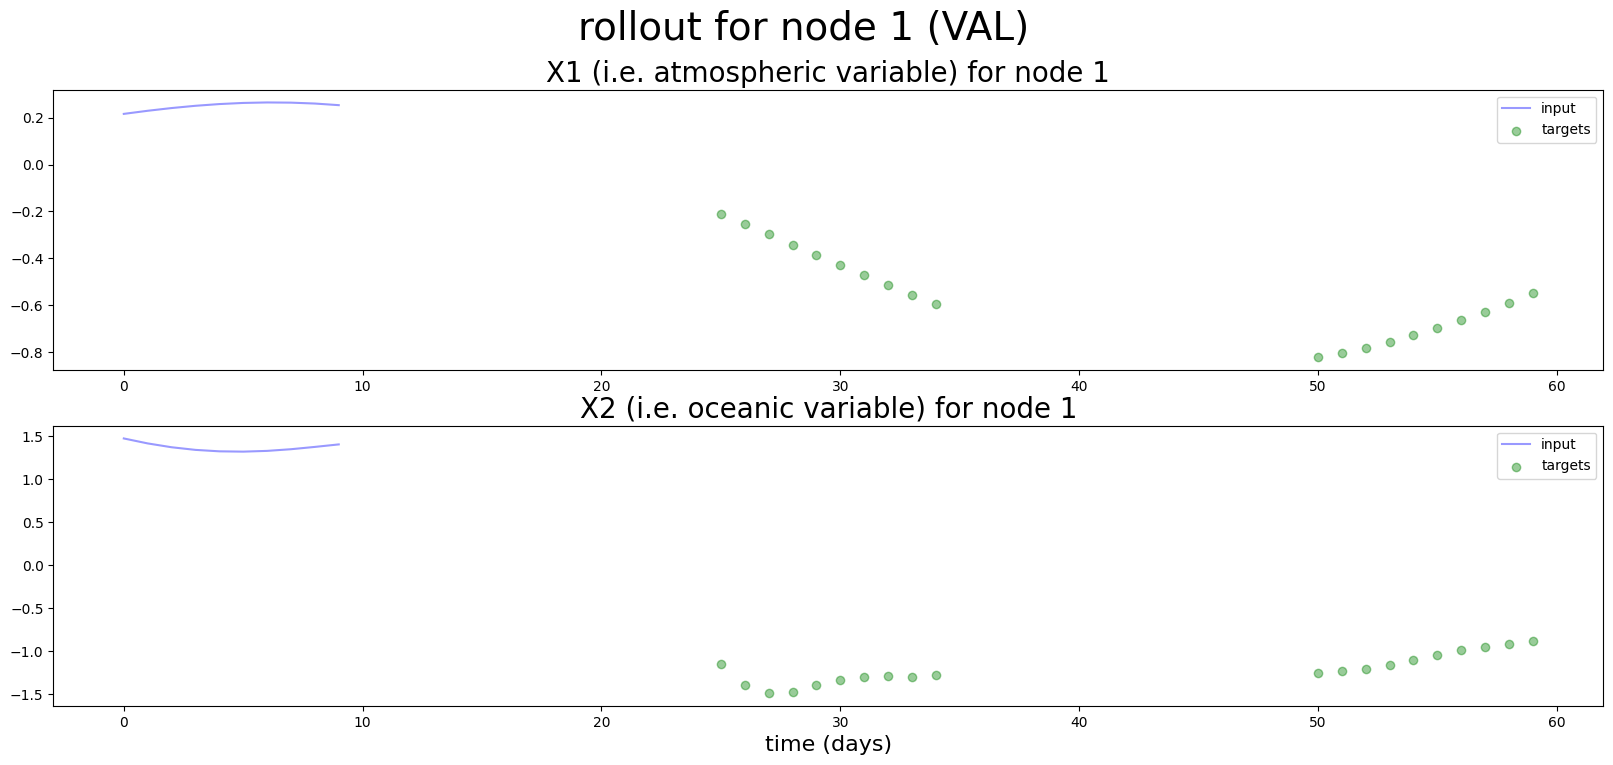

In [511]:
data_dict_lists = {
    'train':
    data_list_to_dict(graph_tuple_lists['train'],
                      n_rollout_steps=2,
                      timestep_duration=25),
    'val':
    data_list_to_dict(graph_tuple_lists['val'],
                      n_rollout_steps=2,
                      timestep_duration=25)
}
plot_rollout_for_node(data_dict_lists['train'],
                      timestep_duration=25,
                      n_rollout_steps=2,
                      node=1, title=f'rollout for node 1 (TRAIN)')
plot_rollout_for_node(data_dict_lists['val'],
                      timestep_duration=25,
                      n_rollout_steps=2,
                      node=1, title=f'rollout for node 1 (VAL)')


great, this matches the original lorenz data so we did the data handling correctly. 

### train MLPBlock

get data

In [512]:
graph_tuple_lists = lorenz_graph_tuple_list(n_samples=2_000)
data_dict_lists = {
    'train':
    data_list_to_dict(graph_tuple_lists['train'],
                      n_rollout_steps=1,
                      timestep_duration=25),
    'val':
    data_list_to_dict(graph_tuple_lists['val'],
                      n_rollout_steps=1,
                      timestep_duration=25)
}


done computing adj
1400 1375
600 575


train

In [590]:
epochs = 50
params_block = train(MLPBlock_fn, data_dict_lists['train'], num_train_steps=epochs*len(data_dict_lists['train']))

preds.shape (36, 2)
targets.shape (36, 2)
()
step: 0, loss: 1.966522216796875, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 50, loss: 1.3304328918457031, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 100, loss: 0.8535153269767761, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 150, loss: 0.8804299235343933, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 200, loss: 1.0041786432266235, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 250, loss: 0.884207010269165, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 300, loss: 0.8702329397201538, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 350, loss: 0.8869522213935852, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 400, loss: 0.8643324375152588, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 450, loss: 0.8622950315475464, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 500, loss: 0.9804996848106384, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 550, loss: 0.8300782442092896,

In [591]:
train_loss_block, train_preds_block = evaluate(MLPBlock_fn, data_dict_lists['train'], params_block)
val_loss_block, val_preds_block = evaluate(MLPBlock_fn, data_dict_lists['val'], params_block)

preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Evaluated 601 graphs
Evaluated 701 graphs
Evaluated 801 graphs
Evaluated 901 graphs
Evaluated 1001 graphs
Evaluated 1101 graphs
Evaluated 1201 graphs
Evaluated 1301 graphs
Completed evaluation.
Eval loss: 0.8654738664627075
preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Completed evaluation.
Eval loss: 0.8856605291366577


In [592]:
print(train_loss_block)
print(val_loss_block)

0.86547387
0.8856605


#### visualize predictions

In [593]:
len(train_preds_block)
len(val_preds_block)

575

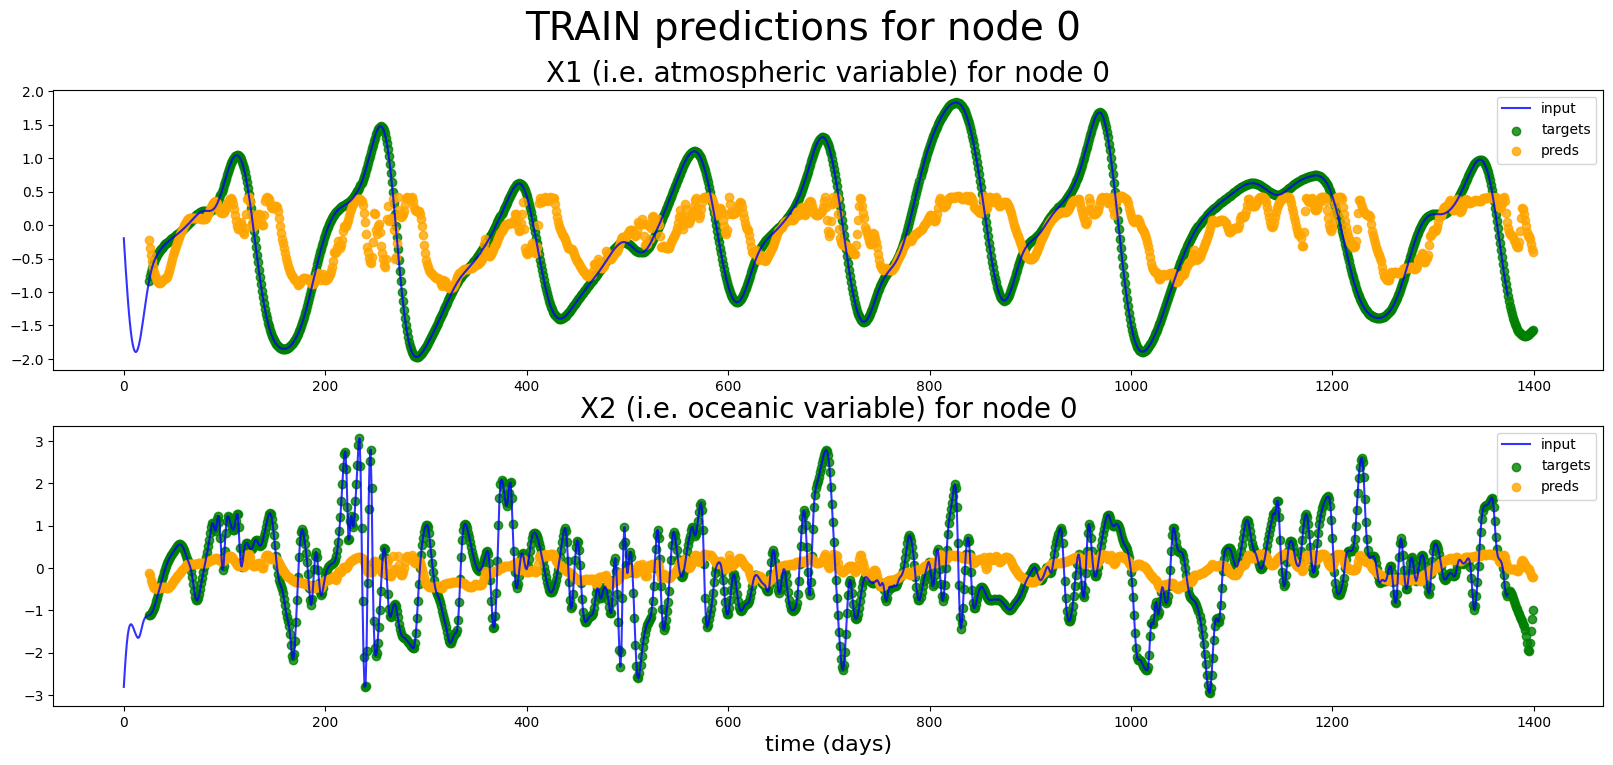

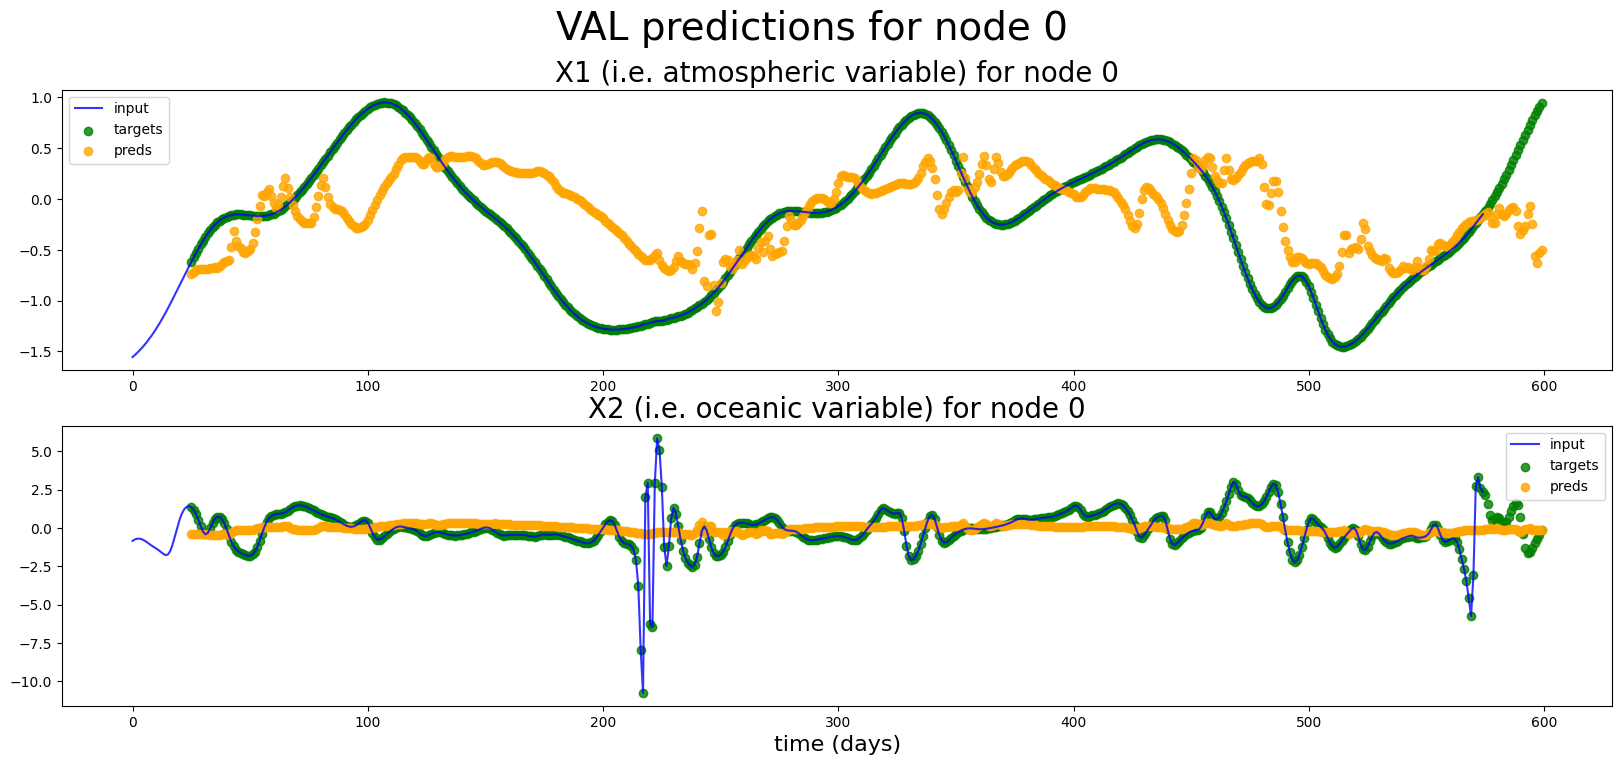

In [594]:
node = 0
plot_predictions(data_dict_lists['train'],
                 train_preds_block,
                 timestep_duration=25,
                 n_rollout_steps=1,
                #  total_steps=2_000,
                 node=node,
                 title=f"TRAIN predictions for node {node}")
plot_predictions(data_dict_lists['val'],
                 val_preds_block,
                 timestep_duration=25,
                 n_rollout_steps=1,
                #  total_steps=2_000,
                 node=node,
                 title=f"VAL predictions for node {node}")


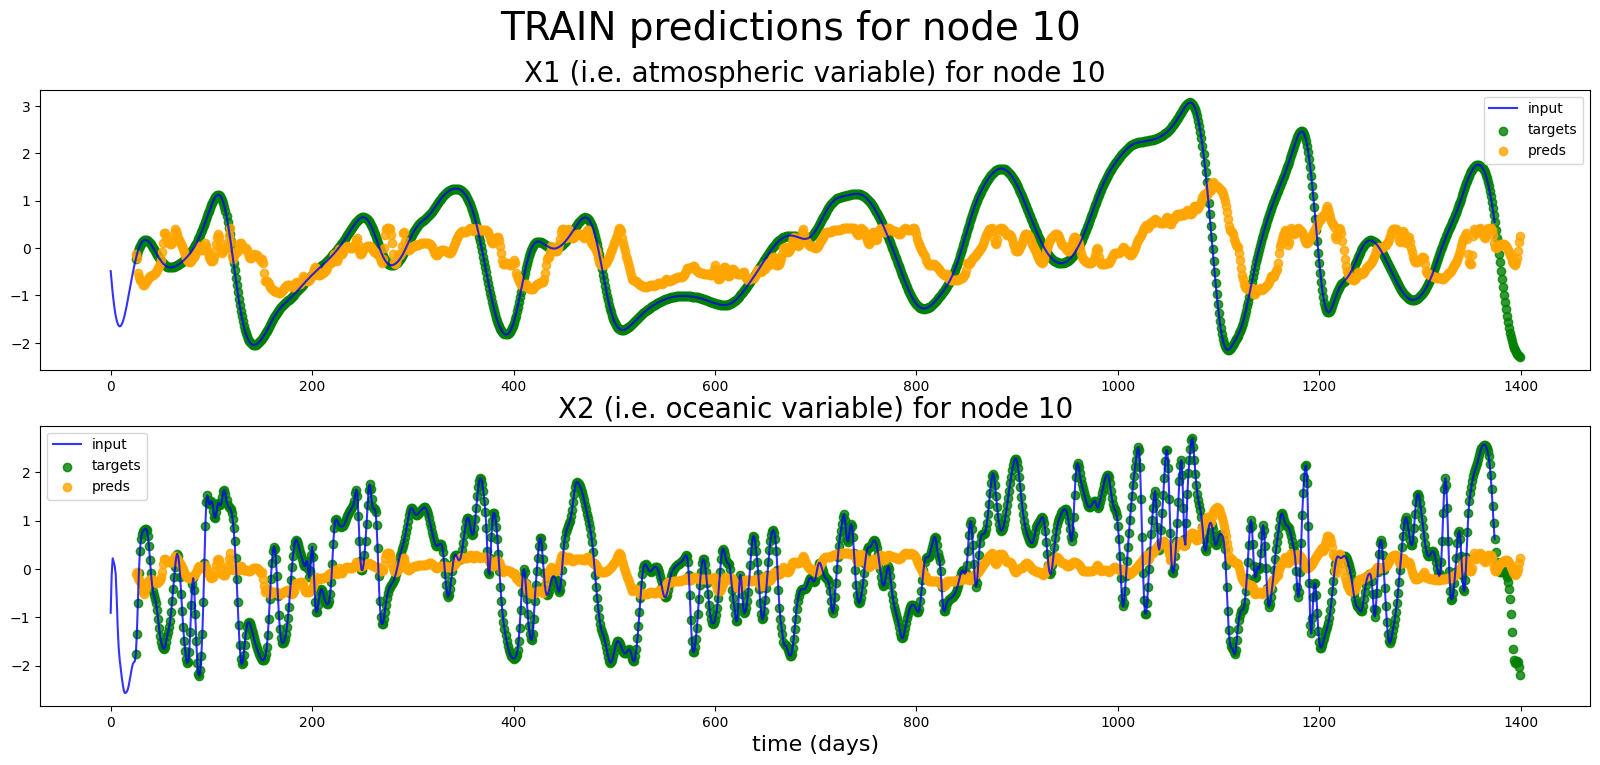

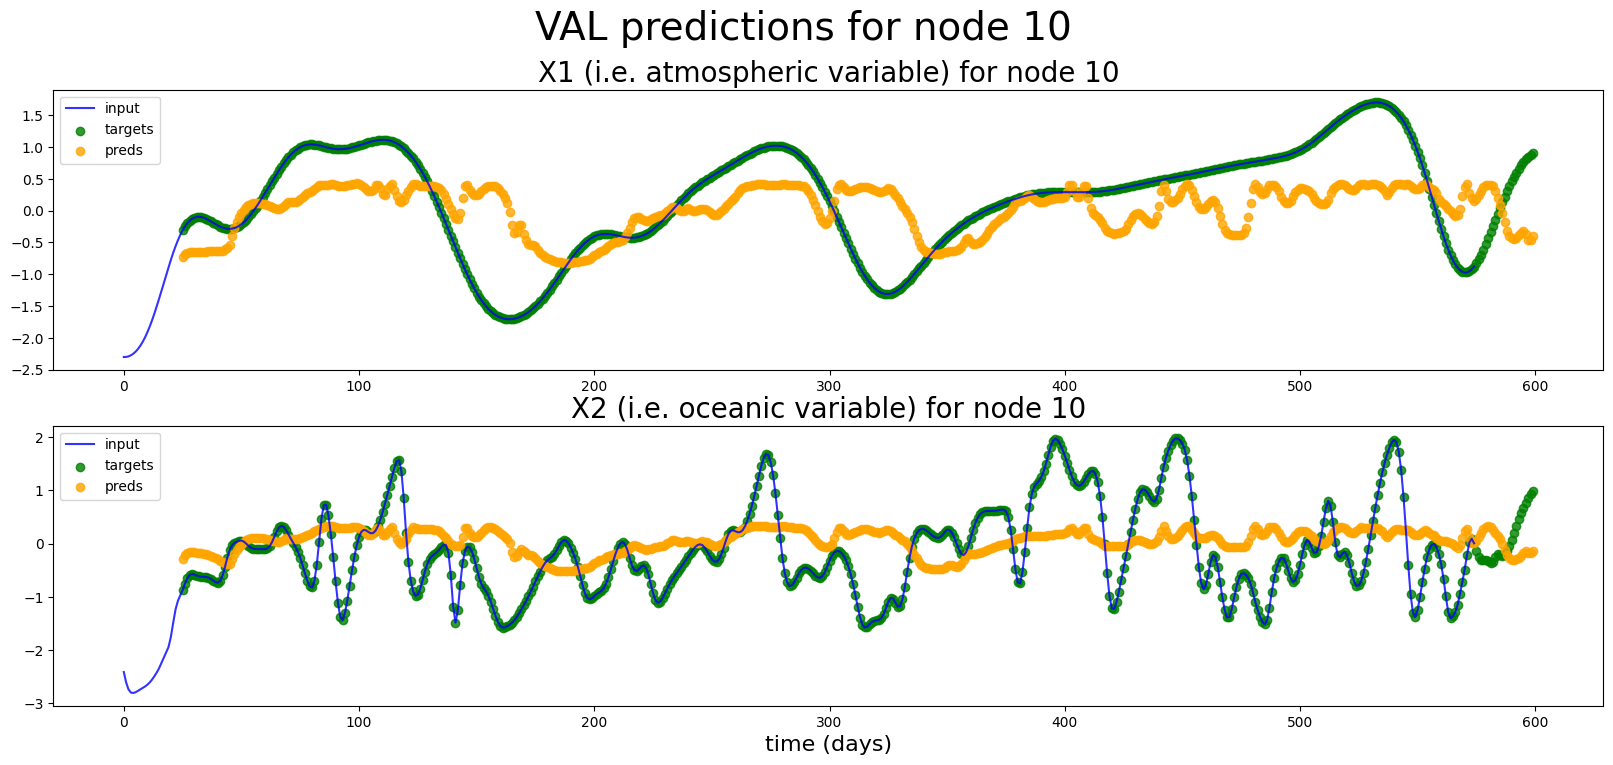

In [569]:
node = 10
plot_predictions(data_dict_lists['train'],
                 train_preds_block,
                 timestep_duration=25,
                 n_rollout_steps=1,
                #  total_steps=2_000,
                 node=node,
                 title=f"TRAIN predictions for node {node}")
plot_predictions(data_dict_lists['val'],
                 val_preds_block,
                 timestep_duration=25,
                 n_rollout_steps=1,
                #  total_steps=2_000,
                 node=node,
                 title=f"VAL predictions for node {node}")


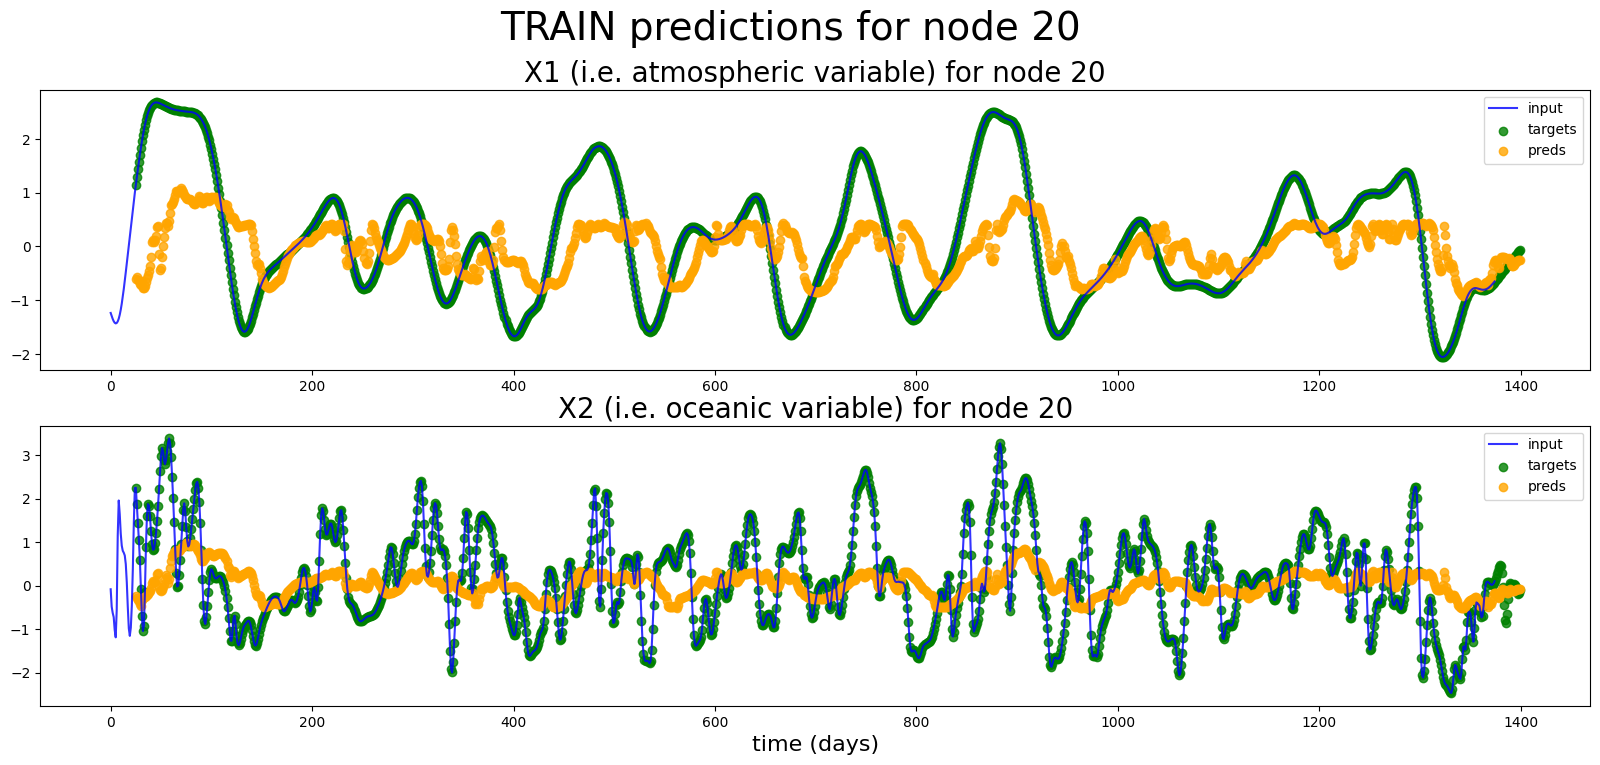

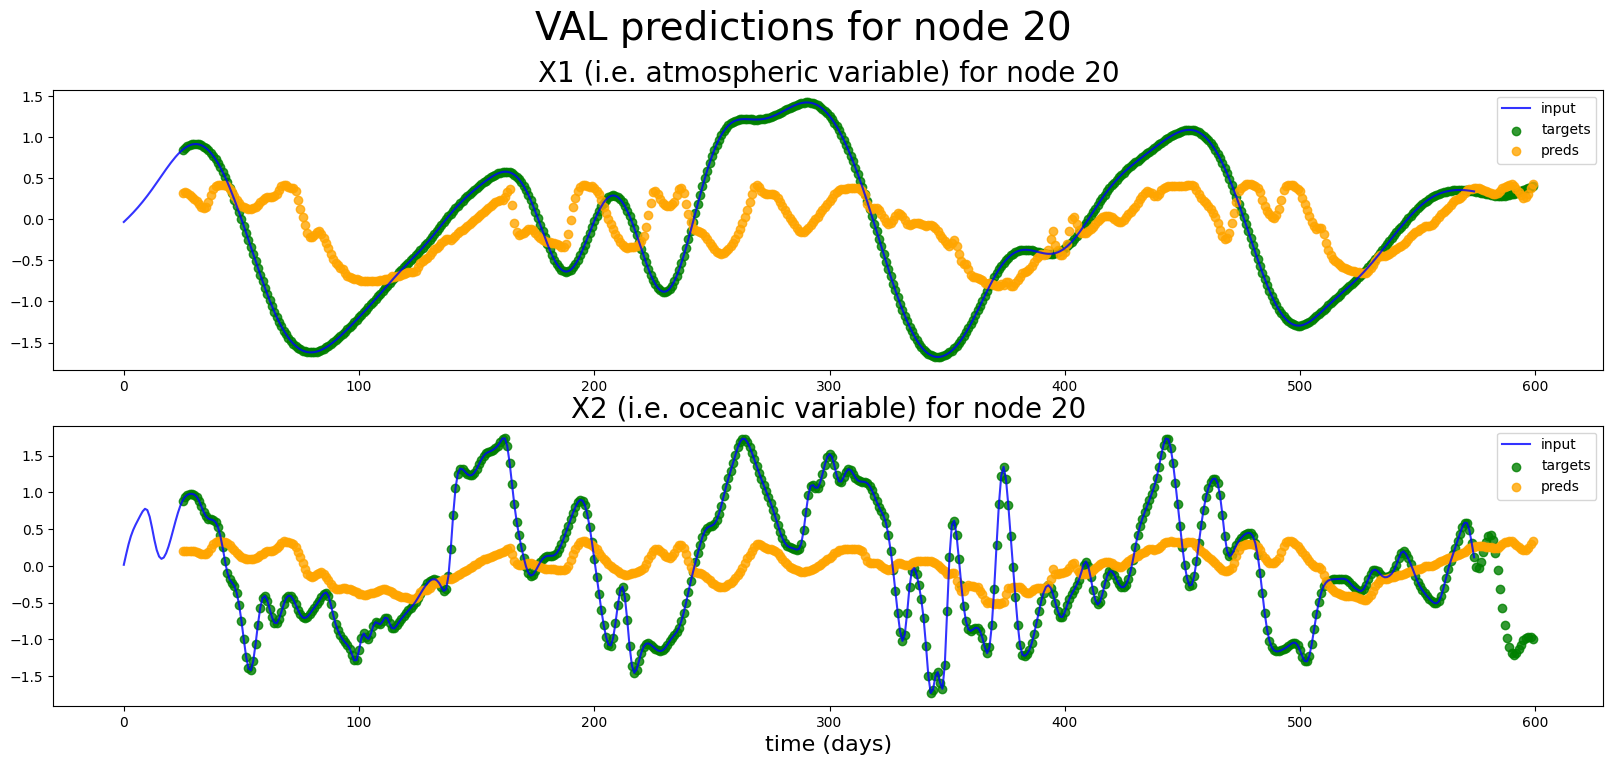

In [570]:
node = 20
plot_predictions(data_dict_lists['train'],
                 train_preds_block,
                 timestep_duration=25,
                 n_rollout_steps=1,
                #  total_steps=2_000,
                 node=node,
                 title=f"TRAIN predictions for node {node}")
plot_predictions(data_dict_lists['val'],
                 val_preds_block,
                 timestep_duration=25,
                 n_rollout_steps=1,
                #  total_steps=2_000,
                 node=node,
                 title=f"VAL predictions for node {node}")


good: we are actually getting some results that aren't just collapse to the mean!

bad: its making very naive predictions and basically just predicting the same thing into the future...

### train MLPNetwork

In [560]:
epochs = 50
params_MLPNet = train(MLPGraphNetwork_fn, data_dict_lists['train'], num_train_steps=epochs*len(data_dict_lists['train']))

preds.shape (36, 2)
targets.shape (36, 2)
()
step: 0, loss: 1.8158307075500488, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 50, loss: 1.2941595315933228, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 100, loss: 0.8772857785224915, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 150, loss: 0.8322122693061829, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 200, loss: 0.9857876896858215, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 250, loss: 0.9259876608848572, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 300, loss: 0.95790034532547, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 350, loss: 0.9477318525314331, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 400, loss: 0.9714544415473938, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 450, loss: 0.9183100461959839, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 500, loss: 0.9989378452301025, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 550, loss: 0.8700799942016602,

In [561]:
train_loss_MLPNet, train_preds_MLPNet = evaluate(MLPGraphNetwork_fn, data_dict_lists['train'],
                                     params_MLPNet)
val_loss_MLPNet, val_preds_MLPNet = evaluate(MLPGraphNetwork_fn, data_dict_lists['val'],
                                     params_MLPNet)


preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Evaluated 601 graphs
Evaluated 701 graphs
Evaluated 801 graphs
Evaluated 901 graphs
Evaluated 1001 graphs
Evaluated 1101 graphs
Evaluated 1201 graphs
Evaluated 1301 graphs
Completed evaluation.
Eval loss: 0.8769784569740295
preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Completed evaluation.
Eval loss: 0.8955565094947815


In [562]:
print(train_loss_MLPNet)
print(val_loss_MLPNet)

0.87697846
0.8955565


#### visualize predictions

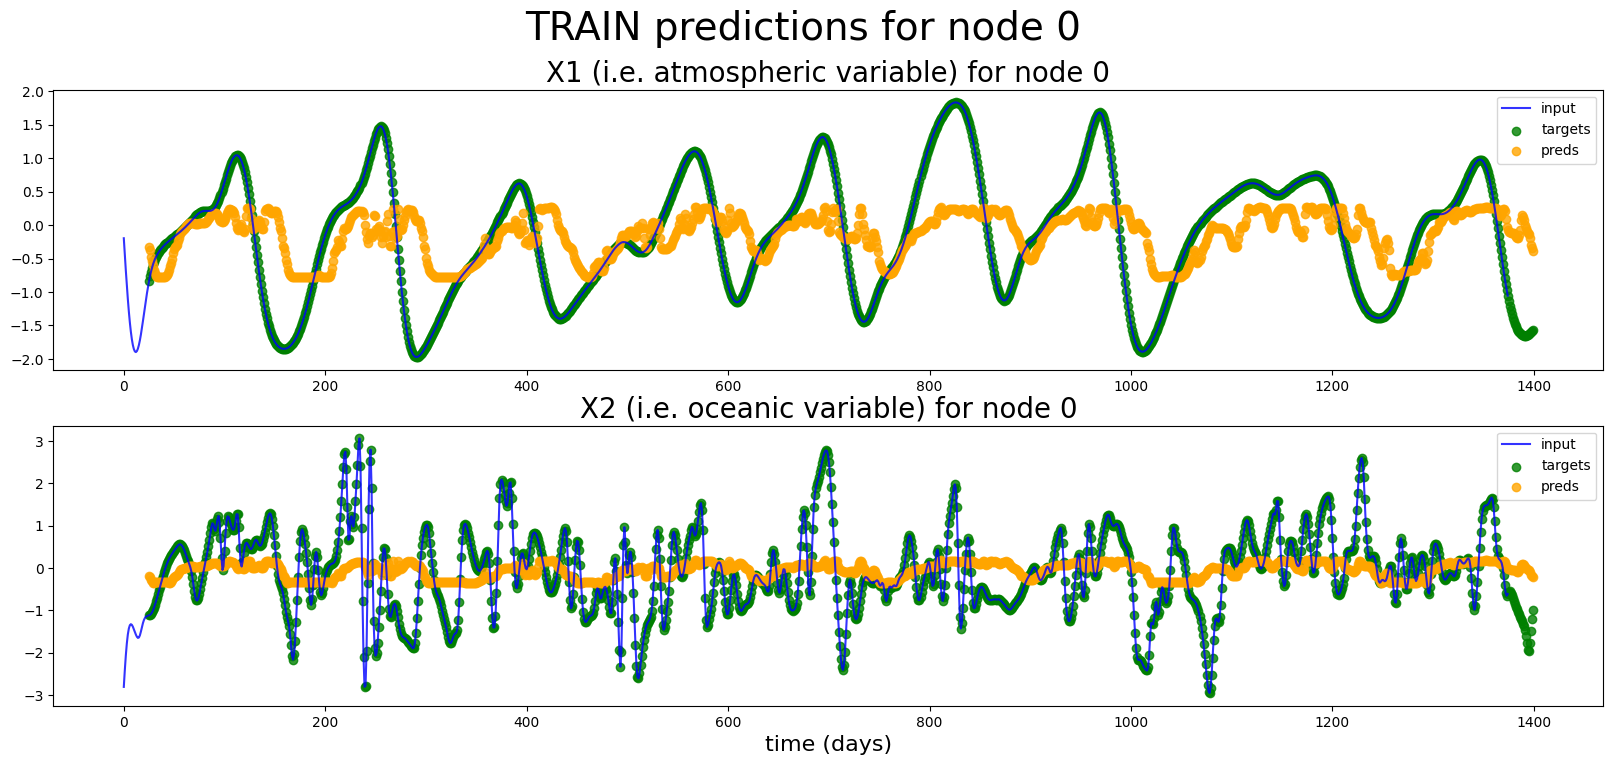

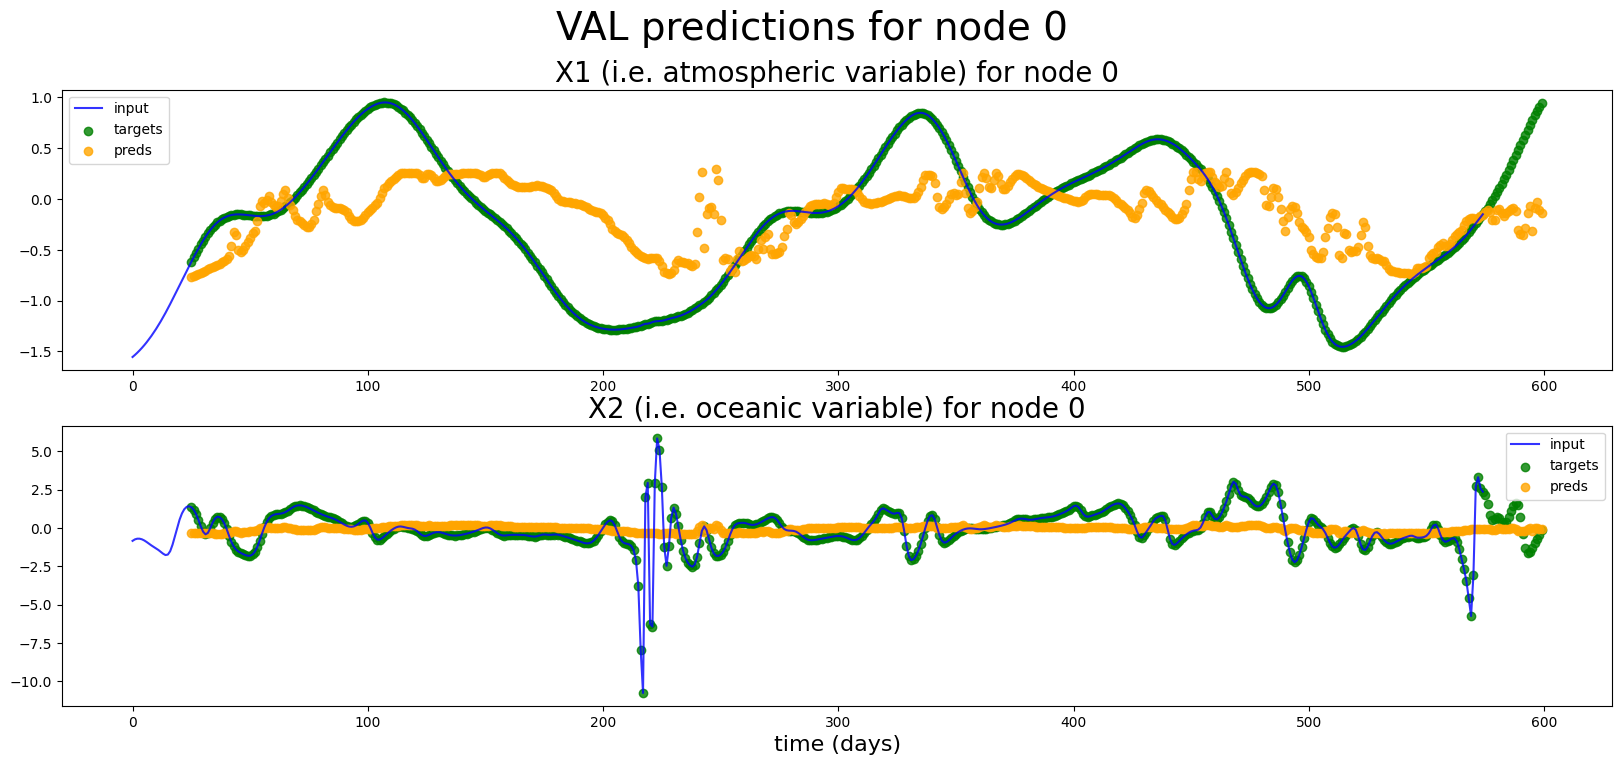

In [563]:
node = 0
plot_predictions(data_dict_lists['train'],
                 train_preds_MLPNet,
                 timestep_duration=25,
                 n_rollout_steps=1,
                 node=node,
                 title=f"TRAIN predictions for node {node}")
plot_predictions(data_dict_lists['val'],
                 val_preds_MLPNet,
                 timestep_duration=25,
                 n_rollout_steps=1,
                 node=node,
                 title=f"VAL predictions for node {node}")


### compare with naive constant baseline
predict that future data is the same as current data

In [531]:
params_naive_const = train(naive_const_fn, data_dict_lists['train'], num_train_steps=1)
loss_naive_const, preds_naive_const = evaluate(naive_const_fn, data_dict_lists['train'],
                                               params_naive_const)


preds.shape (36, 2)
targets.shape (36, 2)
()
step: 0, loss: 3.3471310138702393, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
Training finished
preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Evaluated 601 graphs
Evaluated 701 graphs
Evaluated 801 graphs
Evaluated 901 graphs
Evaluated 1001 graphs
Evaluated 1101 graphs
Evaluated 1201 graphs
Evaluated 1301 graphs
Completed evaluation.
Eval loss: 1.5337852239608765


In [532]:
print(loss_naive_const)

1.5337852


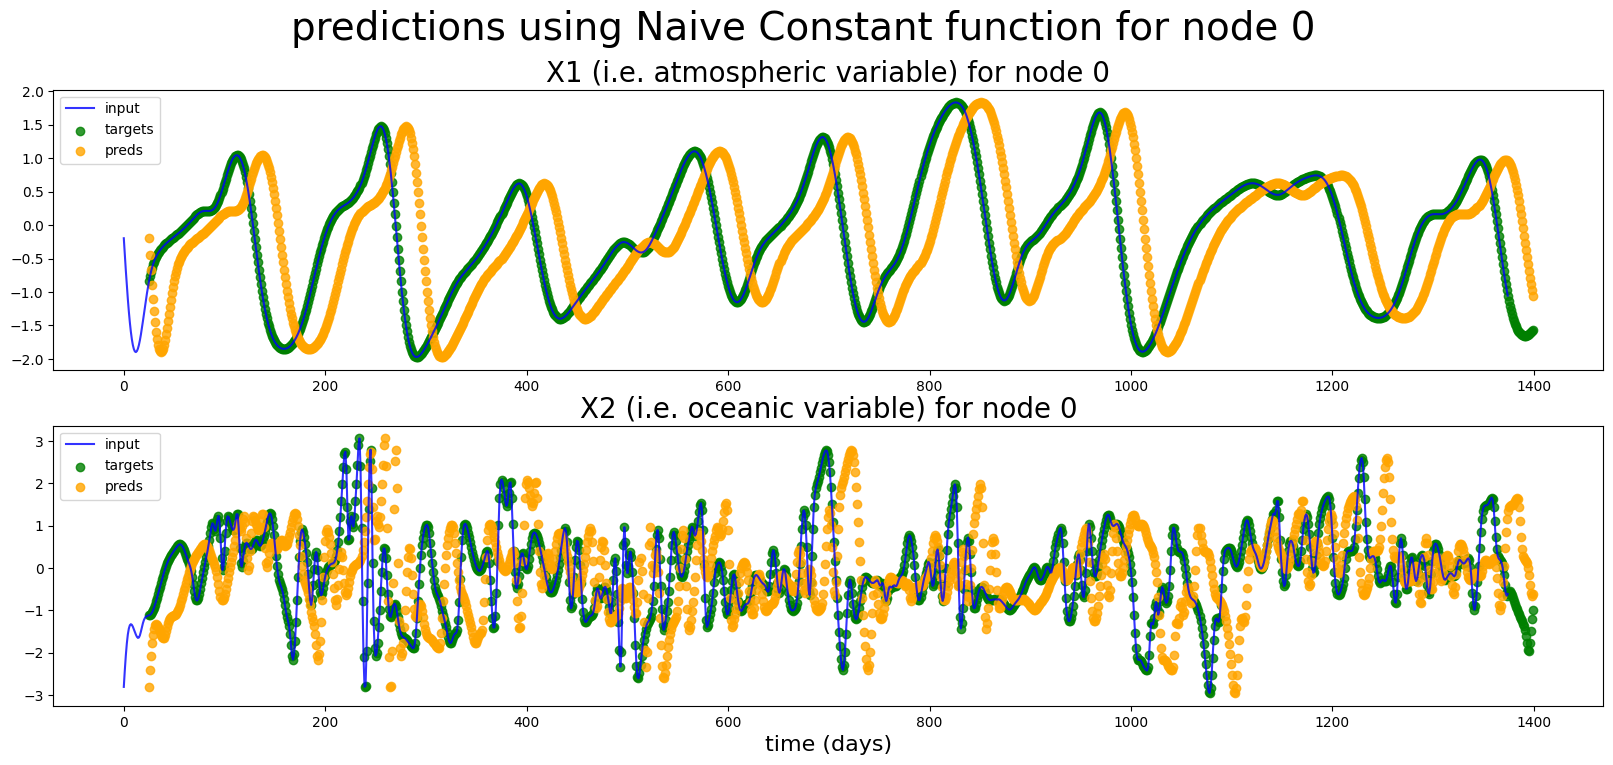

In [534]:
plot_predictions(data_dict_lists['train'],
                 preds_naive_const,
                 timestep_duration=25,
                 n_rollout_steps=1,
                 node=0,
                 title='predictions using Naive Constant function for node 0')


### compare with naive zero baseline
always predict features are 0 (mean)

In [535]:
params_naive_zero = train(naive_zero_fn, data_dict_lists['train'], num_train_steps=1)
loss_naive_zero, preds_naive_zero = evaluate(naive_zero_fn, data_dict_lists['train'],
                                             params_naive_zero)
loss_naive_zero

preds.shape (36, 2)
targets.shape (36, 2)
()
step: 0, loss: 1.8175904750823975, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
Training finished
preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Evaluated 601 graphs
Evaluated 701 graphs
Evaluated 801 graphs
Evaluated 901 graphs
Evaluated 1001 graphs
Evaluated 1101 graphs
Evaluated 1201 graphs
Evaluated 1301 graphs
Completed evaluation.
Eval loss: 0.9759009480476379


Array(0.97590095, dtype=float32)

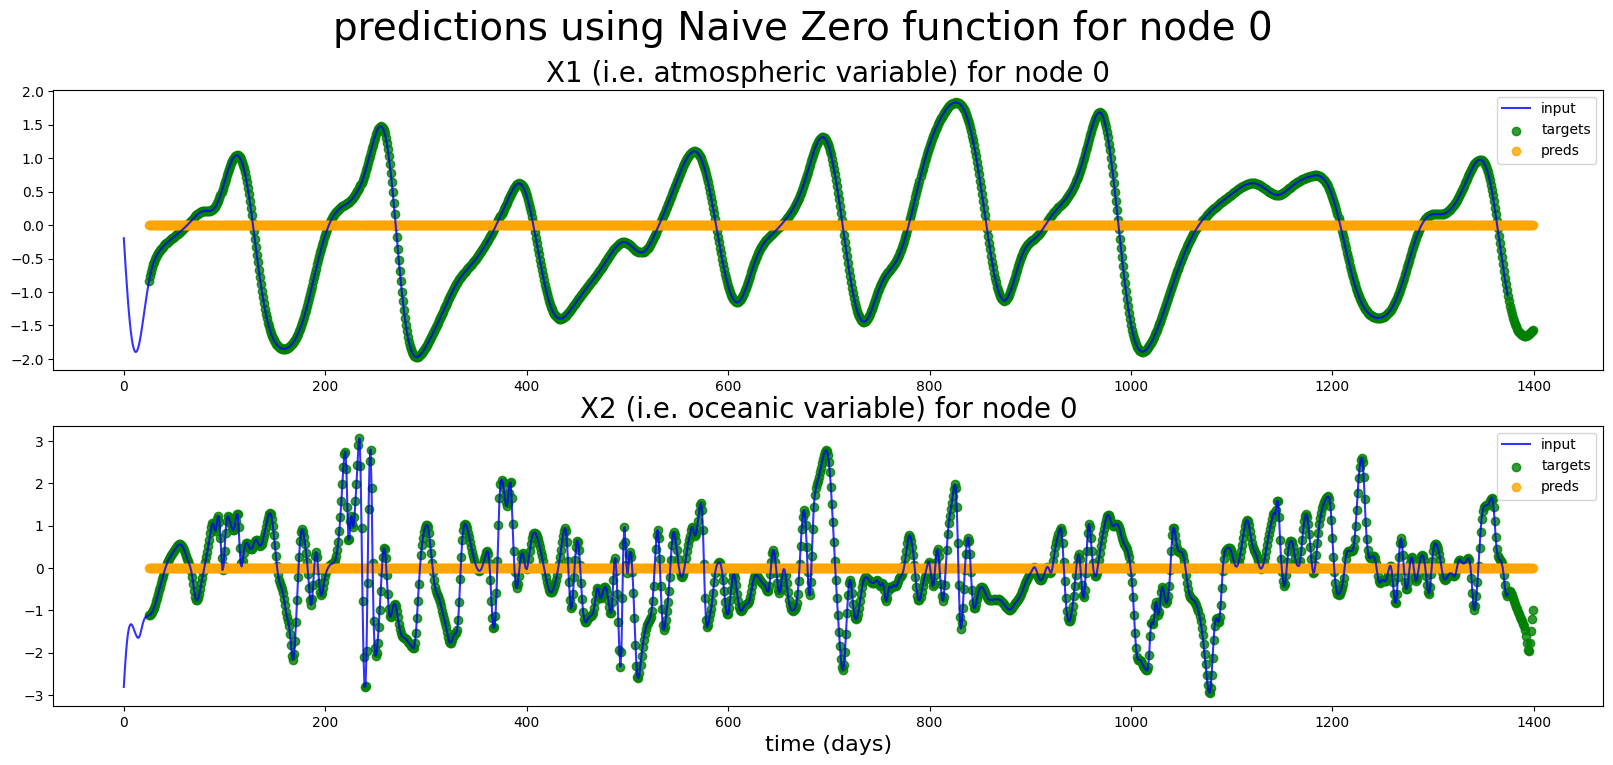

In [536]:
plot_predictions(data_dict_lists['train'],
                 preds_naive_zero,
                 timestep_duration=25,
                 n_rollout_steps=1,
                 node=0,
                 title='predictions using Naive Zero function for node 0')
